## Fixed Data:

In [31]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import numpy as np
import requests
import pandas as pd
from fredapi import Fred

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

In [14]:
fred = Fred(api_key=FRED_API_KEY)
Risk_free_rate = fred.get_series('DGS1MO', frequency = 'wem')
Risk_free_rate = Risk_free_rate.to_frame()
Risk_free_rate = Risk_free_rate.reset_index()
Risk_free_rate = Risk_free_rate.rename(columns={'index':'Date', 0:'RiskFree'})

In [15]:
Risk_free_rate.tail()

,Date,RiskFree
1079,2022-04-11,0.20
1080,2022-04-18,0.31
1081,2022-04-25,0.42
1082,2022-05-02,0.38
1083,2022-05-09,NaN


## Get Multiple Attributes for Multiple Coins:

In [16]:
### Define a function to pull data according to input values(coin, feature)
### After running this method, it should return pulled data, and also store it in memory named as "coin_feature"

def PullData(coin, feature):
    ##print(f"Pulling {coin}'s {feature} data")

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin, 'api_key': API_KEY, 'i':'1w'})
    data_raw = pd.read_json(res.text, convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v" : f"{feature}", 't':'Date'})

    # Turn renamed dataframe into a global variable for future using
    name = f"{coin}_{feature}"
    globals()[name] = data

    # Return a dataframe
    return data

In [17]:
### Get all features(listed in endPoints) of all coins(listed in symbolListShort) 

from functools import reduce

for i in symbolList:
    ##print(f"Start Pulling {i}'s data:")

    # Preparation for merging
    frameName = f"{i}_Frames"
    locals()[frameName] = []

    # Get data
    for j in list(endPoints.keys()):
        locals()[frameName].append(PullData(i, j))

    # Merge to single dataframe
    ##print('Merging Dataframes...')
    dfName = f"{i}_Raw"
    locals()[dfName] = reduce(lambda  left,right: pd.merge(left,right, on='Date', how='inner'), locals()[frameName])
    locals()[dfName] = locals()[dfName].merge(Risk_free_rate, on='Date', how='left')

    ##print(f"{i} data successfully pulled\n")
##print('\nALL DATA SUCCESSFULLY PULLED!')

In [18]:
BTC_Raw.to_csv("C:/Users/杨仲伯/Desktop/BTC_weekly.csv")

# NET: Network Factor

The network factor (NET) is constructed by splitting the coins of the Core Sample into 3 groups due to the limitation of available coins. Particularly, each week we split the cryptocurrencies into three [30% 40% 30%] groups by the growth rate in total addresses with balance. The network factor (NET) is the return difference between the top and the bottom network portfolios. 

## Get address growth

In [13]:
NET = pd.DataFrame({'Date':[]})
NET.Date = BTC_Raw.Date

for i in symbolList:
    dfName = f"{i}_Raw"

    copy1 = f"{i}1"
    locals()[copy1] = locals()[dfName].copy()
    copy2 = f"{i}2"
    locals()[copy2] = locals()[dfName].copy()
    locals()[copy2] = locals()[copy2].shift()

    df_NET = f"{i}_NET"
    locals()[df_NET] = pd.DataFrame({'Date':[],f"{i}":[]})
    locals()[df_NET]['Date'] = locals()[copy1]['Date']
    locals()[df_NET][f"{i}"] = np.log(locals()[copy1]['ActiveAddress'])-np.log(locals()[copy2]['ActiveAddress'])

    NET = NET.merge(locals()[df_NET], left_on='Date', right_on='Date', how='outer')
    
NET['30Percentile'] = NET.quantile(q=0.3, numeric_only = True, axis = 1)
NET['70Percentile'] = NET.quantile(q=0.7, numeric_only = True, axis = 1)

C:\ZacharyYang\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Get Return

In [44]:
Return = pd.DataFrame({'Date':[]})
Return['Date'] = NET.Date
for i in symbolList:
    
    dfName = f"{i}_Raw" 
    df = f"{i}_Return"
    locals()[df] = pd.DataFrame({'Date':[]})
    locals()[df].Date = locals()[dfName].Date
    locals()[df][f"{i}"] = locals()[dfName].Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])

    Return = Return.merge(locals()[df], left_on='Date', right_on='Date', how='outer')

## Construct Network factor

In [83]:
C5 = pd.DataFrame({'Date':[]})
C5.Date = NET.Date
C5['short'] = Return[NET[symbolList].apply(lambda x: x <= NET['30Percentile'])].mean(axis=1, numeric_only= True)
C5['long'] = Return[NET[symbolList].apply(lambda x: x >= NET['70Percentile'])].mean(axis=1, numeric_only= True)
C5.fillna(value = 0, inplace=True)
C5['NET'] = C5.long - C5.short
C5.drop(columns=['short', 'long'], inplace=True)
C5.tail()

,Date,NET
611,2022-03-28,-0.328270
612,2022-04-04,0.256623
613,2022-04-11,-0.035431
614,2022-04-18,-0.009535
615,2022-04-25,0.052962


In [ ]:
C5.tail(200)

In [91]:
pd.set_option('display.max_rows', 500)
## so many null values
# because a lot of null in Return table,  
# In turn 



## Verification

Text(0, 0.5, 'Cumulative Return')

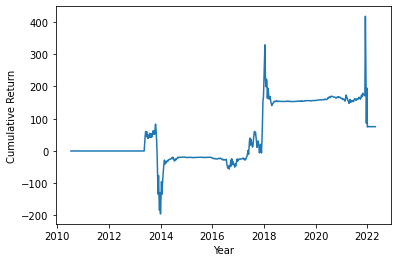

In [85]:
import matplotlib.pyplot as plt

plt.plot(C5.Date, np.cumsum(C5.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')